# Shizhong's original code without modifications*

`* Except...
Here's a block of code we had to add
  ```
    if(!is.data.frame(fit)){
        if(fit == "err"){
            next
        }
    }

    if(nrow(fit) == 0) next
  ```
Instead of just
  ```
      if(fit == "err") next`
  ```

Also, in version c, we replace `elastic.net` with version that works for both `1se` and `min`. We use `1se` in version 

In [1]:
#new lines
load("p1.rda")

In [2]:
library("glmnet")
library("e1071")
library("doParallel")
source("model.R")

args = commandArgs(trailingOnly=TRUE)

set.seed(2018)
wind <- c(5000,10000)
# output directory
#outd <- "/dcl02/lieber/shan/shizhong/finemapping/GWAS/tags/scz3/mwas/chr22/1/"
outd <- "27-OUT/"

# load data for mwas
# load("./rda/caudate_mwas_data_chr22.rda")
#load(as.character(args[2]))
load("BSsample.rda")

# candidate cg
cg <- as.numeric(rownames(p))

Loading required package: Matrix

Loaded glmnet 4.1-8

Loading required package: foreach

Loading required package: iterators

Loading required package: parallel



In [3]:
# modified to use lambda 1se and appropriate cvm
elastic.net <- function(trainX,trainY, lambda.choice = "1se"){
    if(nrow(trainX)!=length(trainY)){
            stop("Number of observations is differerent")
    } 

    # optimize alpha---mixing parameter  
    a <- 0.5
    search <- foreach(ai = a, .combine = rbind) %dopar% {
        #set.seed(42)
        cv.fit <- cv.glmnet(
                        trainX,
                        trainY,
                        nfold = 5,
                        type.measure = "mse",
                        parallel = TRUE,
                        alpha = ai
                        )
        #print(paste0("Dim of trainX: ", dim(trainX)))
        #print(paste0("Len of trainY: ", length(trainY)))
        coef_matrix <- as.matrix(coef(cv.fit))

        if(lambda.choice == "1se"){
            chosen_lambda <- cv.fit$lambda.1se
            chosen_cvm <- cv.fit$cvm[cv.fit$lambda == cv.fit$lambda.1se]
        }
        if(lambda.choice == "min"){
            chosen_lambda <- cv.fit$lambda.min
            chosen_cvm <- min(cv.fit$cvm)
        }


        data.frame(
                        cvm = chosen_cvm,
                        lambda = chosen_lambda,
                        alpha = ai
                        )
        } 
    cv.opt <- search[search$cvm == min(search$cvm),] 

        # fit model by optimized alpha and lambda
    #set.seed(42)
    yfit <- glmnet(
    trainX,
    trainY,
    lambda = cv.opt$lambda,
    alpha = cv.opt$alpha)

    idf <- coef(yfit)
    idx <- which(idf != 0)
    selectf <- data.frame(
            features = idf@Dimnames[[1]][idx], 
            coefs = idf [idx]
    )
}

In [4]:
# regress out covariates
load("covs_for_meqtl.rda")
mat <- match(BSsample$brnum,colnames(covs)) 
covs <- t(covs[,mat])
p.residual=matrix(0,dim(p)[1],dim(p)[2])
for(i in 1:dim(p)[1]){
	dat <- as.data.frame(cbind(p[i,],covs))
	colnames(dat) <- c("y",paste0("x",1:33))
	model.res <- lm(reformulate(paste0("x",1:33), "y"),dat)
	p.residual[i,] = resid(model.res) 
}

In [5]:
# built predition models
idx.ea <- BSsample$race == "CAUC"
for(k in 1:length(wind)){
models.ea <- c()
models.all <- c()
for(i in 1:length(cg)){
	cat(i,"\n")
	range1 <- ifelse(cg[i] - wind[k] > 0,cg[i] - wind[k],0)
	range2 <- cg[i] + wind[k]
	idx <- map2$POS > range1 & map2$POS < range2
	# go to next cg if no snps within window
	if(sum(idx) <= 1){
		next
	}
	geno <- snp2[idx,]
	rownames(geno) <- map2$POS[idx]
	trainX <- t(geno)
	trainY <- p.residual[i,]
	fit <- tryCatch(
		elastic.net(trainX,trainY),
		error = function(e) {return ("err")})

    # Here's a block of code we had to add
    if(!is.data.frame(fit)){
        if(fit == "err"){
            next
        }
    }

    if(nrow(fit) == 0) next
    
	fit$cg <- cg[i]	
	models.all <- rbind(models.all,fit)
	# EA only
	trainX <- trainX[idx.ea,]
	if(sum(apply(trainX,2,var)!=0) <= 1){
		next
	}
	trainY <- trainY[idx.ea]	
	fit <- tryCatch(
		elastic.net(trainX,trainY),
		error = function(e) {return ("err")})
    
    if(!is.data.frame(fit)){
        if(fit == "err"){
            next
        }
    }

    if(nrow(fit) == 0) next
    
	fit$cg <- cg[i]
	models.ea <- rbind(models.ea,fit)
}
models.ea <- models.ea[models.ea[,1] != "(Intercept)",]
models.all <- models.all[models.all[,1] != "(Intercept)",]

# mwas by models of all samples
cg2 <- unique(models.all$cg)
mwas.all <- matrix(0,nrow=length(cg2),ncol=2)
for(i in 1:length(cg2)){
	pos <- models.all[models.all$cg == cg2[i],1]
	gwas <- snp.gwas2$z[is.element(snp.gwas2$pos_hg38, pos)]
	weight <- models.all[models.all$cg == cg2[i],2]
	geno <- snp.1kg.eur2[match(pos,map.1kg.eur2$POS),]
	mwas.all[i,] <- MWAS(gwas, weight, t(geno))
}
rownames(mwas.all) <- cg2
colnames(mwas.all) <- c("z","p")

# mwas by models of EA samples
cg2 <- unique(models.ea$cg)
mwas.ea <- matrix(0,nrow=length(cg2),ncol=2)
for(i in 1:length(cg2)){
	pos <- models.ea[models.ea$cg == cg2[i],1]
	gwas <- snp.gwas2$z[is.element(snp.gwas2$pos_hg38, pos)]
	weight <- models.ea[models.ea$cg == cg2[i],2]
	geno <- snp.1kg.eur2[match(pos,map.1kg.eur2$POS),]
	mwas.ea[i,] <- MWAS(gwas, weight, t(geno))
}
rownames(mwas.ea) <- cg2
colnames(mwas.ea) <- c("z","p")

# output models and mwas results
outf <- paste0(outd,"/models.all.wind.a27b.",wind[k])
write.csv(models.all,outf)
outf <- paste0(outd,"/models.ea.wind.a27b.",wind[k])
write.csv(models.ea,outf)
outf <- paste0(outd,"/mwas.all.wind.a27b.",wind[k])
write.csv(mwas.all,outf)
outf <- paste0(outd,"/mwas.ea.wind.a27b.",wind[k])
write.csv(mwas.ea,outf)
}
	

1 


Warning message:
“executing %dopar% sequentially: no parallel backend registered”


2 
3 
4 
5 
6 
7 
8 
9 
10 
11 
12 
13 
14 
15 
16 
17 
18 
19 
20 
21 
22 
23 
24 
25 
26 
27 
28 
29 
30 
31 
32 
33 
34 
35 
36 
37 
38 
39 
40 
41 
42 
43 
44 
45 
46 
47 
48 
49 
50 
51 
52 
53 
54 
55 
56 
57 
58 
59 
60 
61 
62 
63 
64 
65 
66 
67 
68 
69 
70 
71 
72 
73 
74 
75 
76 
77 
78 
79 
80 
81 
82 
83 
84 
85 
86 
87 
88 
89 
90 
91 
92 
93 
94 
95 
96 
97 
98 
99 
100 
101 
102 
103 
104 
105 
106 
107 
108 
109 
110 
111 
112 
113 
114 
115 
116 
117 
118 
119 
120 
121 
122 
123 
124 
125 
126 
127 
128 
129 
130 
131 
132 
133 
134 
135 
136 
137 
138 
139 
140 
141 
142 
143 
144 
145 
146 
147 
148 
149 
150 
151 
152 
153 
154 
155 
156 
157 
158 
159 
160 
161 
162 
163 
164 


Warning message:
“from glmnet C++ code (error code -96); Convergence for 96th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”


165 


Warning message:
“from glmnet C++ code (error code -98); Convergence for 98th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -100); Convergence for 100th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”


166 
167 
168 
169 
170 


Warning message:
“from glmnet C++ code (error code -99); Convergence for 99th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”


171 
172 
173 
174 
175 
176 
177 
178 
179 
180 
181 
182 
183 
184 
185 
186 
187 
188 
189 
190 
191 
192 
193 
194 
195 
196 
197 
198 
199 
200 
201 
202 
203 
204 
205 
206 
207 
208 
209 
210 
211 
212 
213 
214 
215 
216 
217 
218 
219 
220 
221 
222 
223 
224 
225 
226 
227 
228 
229 
230 
231 
232 
233 
234 
235 
236 
237 
238 
239 
240 
241 
242 
243 
244 
245 
246 
247 
248 
249 
250 
251 
252 
253 
254 
255 
256 
257 
258 
259 
260 
261 
262 
263 
264 
265 
266 
267 
268 
269 
270 
271 
272 
273 
274 
275 
276 
277 
278 
279 
280 
281 
282 
283 
284 
285 
286 
287 
288 
289 
290 
291 
292 
293 
294 
295 
296 
297 
298 
299 
300 
301 
302 
303 
304 
305 
306 
307 
308 
309 
310 
311 
312 
313 
314 
315 
316 
317 
318 
319 
320 
321 
322 
323 
324 
325 
326 
327 
328 
329 
330 


Warning message:
“from glmnet C++ code (error code -93); Convergence for 93th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -99); Convergence for 99th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”


1 
2 
3 
4 
5 
6 
7 
8 
9 
10 
11 
12 
13 
14 
15 
16 
17 
18 
19 
20 
21 
22 
23 
24 
25 
26 
27 
28 
29 
30 
31 
32 
33 
34 
35 
36 
37 
38 
39 
40 
41 
42 
43 
44 
45 
46 
47 
48 
49 
50 
51 
52 
53 
54 
55 
56 
57 
58 
59 
60 
61 
62 
63 
64 
65 
66 
67 
68 
69 
70 
71 
72 
73 
74 
75 
76 
77 
78 
79 
80 
81 
82 
83 
84 
85 
86 
87 
88 
89 
90 
91 
92 
93 
94 
95 
96 
97 
98 
99 
100 
101 
102 
103 
104 
105 
106 
107 
108 
109 
110 
111 
112 
113 
114 
115 
116 
117 
118 
119 
120 
121 
122 
123 
124 
125 
126 
127 


Warning message:
“from glmnet C++ code (error code -100); Convergence for 100th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -98); Convergence for 98th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -98); Convergence for 98th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -94); Convergence for 94th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -94); Convergence for 94th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”


128 


Warning message:
“from glmnet C++ code (error code -98); Convergence for 98th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -100); Convergence for 100th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”


129 


Warning message:
“from glmnet C++ code (error code -100); Convergence for 100th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -98); Convergence for 98th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”


130 
131 


Warning message:
“from glmnet C++ code (error code -100); Convergence for 100th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”


132 
133 
134 
135 
136 
137 
138 
139 
140 
141 
142 
143 
144 
145 
146 
147 
148 
149 
150 
151 
152 
153 
154 
155 
156 
157 
158 
159 
160 
161 
162 
163 
164 
165 
166 
167 
168 
169 
170 


Warning message:
“from glmnet C++ code (error code -99); Convergence for 99th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”


171 
172 
173 
174 
175 
176 
177 
178 
179 
180 
181 
182 
183 
184 
185 
186 
187 
188 
189 
190 
191 
192 
193 
194 
195 
196 
197 
198 
199 
200 
201 
202 
203 
204 
205 
206 
207 
208 
209 
210 
211 
212 
213 
214 
215 
216 
217 
218 
219 
220 
221 
222 
223 
224 
225 
226 
227 
228 
229 
230 
231 
232 
233 
234 
235 
236 
237 
238 
239 
240 
241 
242 
243 
244 
245 
246 
247 
248 
249 
250 
251 
252 
253 
254 
255 
256 
257 
258 
259 
260 
261 
262 
263 
264 
265 
266 
267 
268 
269 
270 
271 
272 
273 
274 
275 
276 
277 
278 
279 
280 
281 
282 
283 
284 
285 
286 
287 
288 
289 
290 
291 
292 
293 
294 
295 
296 
297 
298 
299 
300 
301 
302 
303 
304 
305 
306 
307 
308 
309 
310 
311 
312 
313 
314 
315 
316 
317 
318 
319 
320 
321 
322 
323 
324 
325 
326 
327 
328 
329 
330 


Warning message:
“from glmnet C++ code (error code -90); Convergence for 90th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”


In [6]:
mwas.all <- as.data.frame(mwas.all)

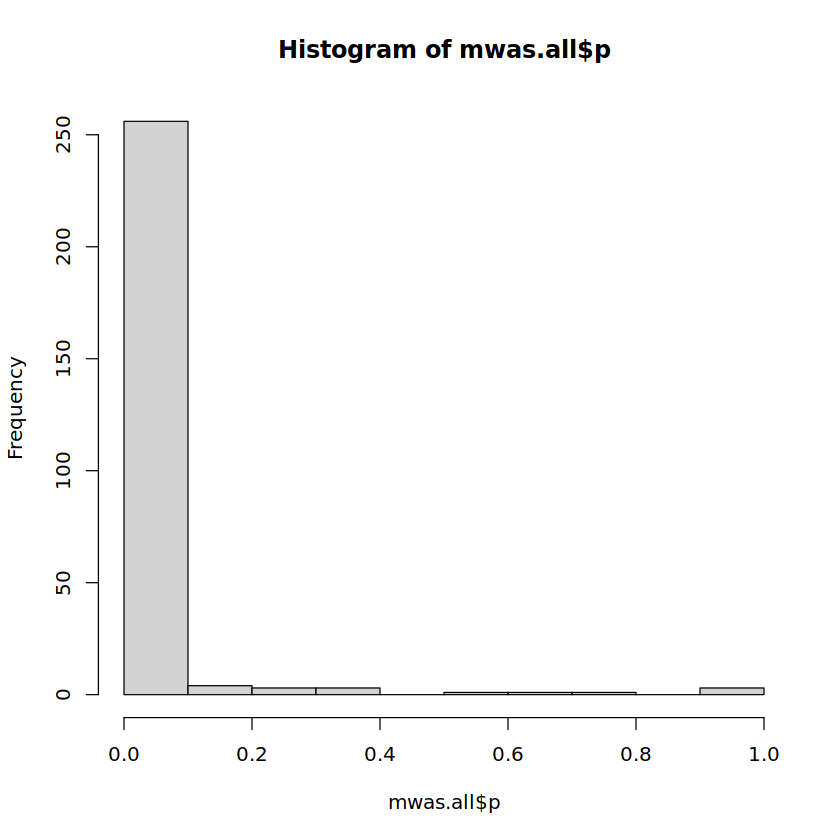

In [7]:
hist(mwas.all$p)

In [8]:
mwas.all

,z,p
,<dbl>,<dbl>
1980077,9.881285,5.018500e-23
1980101,9.796278,1.168111e-22
1980129,9.876082,5.285954e-23
1980136,9.865590,5.868839e-23
1980145,9.870508,5.588094e-23
1980179,9.916470,3.530194e-23
1980183,9.891988,4.509832e-23
1980193,9.915320,3.571095e-23
1980205,9.916223,3.538965e-23


In [9]:
getwd()

[1] "/expanse/lustre/projects/jhu152/naglemi/mwas/CpGWAS/scripts"